# 2D Inversion of Yellowstone Data

Here we will show an example of how to invert profile data in 2D.  These data were collected with the purpose of a 2D inversion.  

First load in the data.  These data are from stations that starts with "SR2" or from the survey 'Yellowstone-Snake_River_Plain'

In [1]:
from pathlib import Path
import numpy as np
from mtpy import MTCollection
from mtpy.modeling.simpeg.recipes import Simpeg2D

In [2]:
%%time
with MTCollection() as mc:
    mc.open_collection(Path().cwd().parent.parent.joinpath("data", "transfer_functions", "yellowstone_mt_collection.h5"))
    #mc.working_dataframe = mc.master_dataframe[mc.master_dataframe.station.str.startswith("SR2")]
    mc.working_dataframe = mc.master_dataframe[mc.master_dataframe.survey == 'Yellowstone-Snake_River_Plain']
    profile_mt_data = mc.to_mt_data()



24:10:30T22:47:28 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing /Users/Mike/git/simpeg_research/earthscope-mt-course/data/transfer_functions/yellowstone_mt_collection.h5
CPU times: user 27.7 s, sys: 616 ms, total: 28.3 s
Wall time: 29 s


## Plot Stations

We want to make sure we got the data we expected. Now notice that there are 2 profiles, one striking northwest and one striking northeast.  

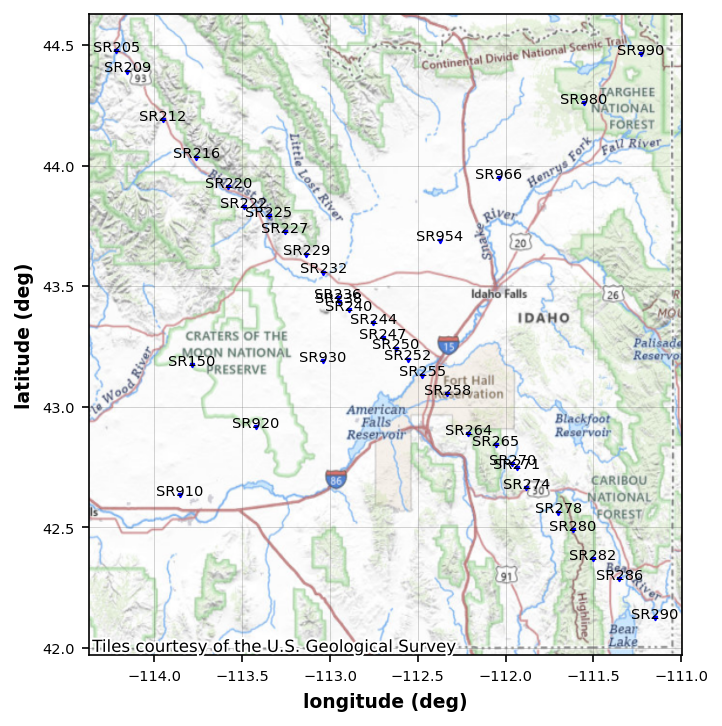

In [3]:
station_plot = profile_mt_data.plot_stations()

## Pick a profile line

Now that we see there are 2 profiles lets creat a line that trends northwest through the dense station coverage.

This data is in UTM Zone WGS84 12N (EPSG: 32612).  We need this estimate distances from a profile line and for modeling.

Here we sent the UTM coordinate system.

In [4]:
profile_mt_data.utm_epsg = 32612

Now we need to set a profile line.  From the map it looks like x1, y1 = (-111, 42.3) and x2, y2 = (-114.5, 44.55). Lets set that as our profile line and pick any station within 10km of the line.

In [5]:
profile = profile_mt_data.get_profile(-111, 42.1, -114.5, 44.55, 15000)

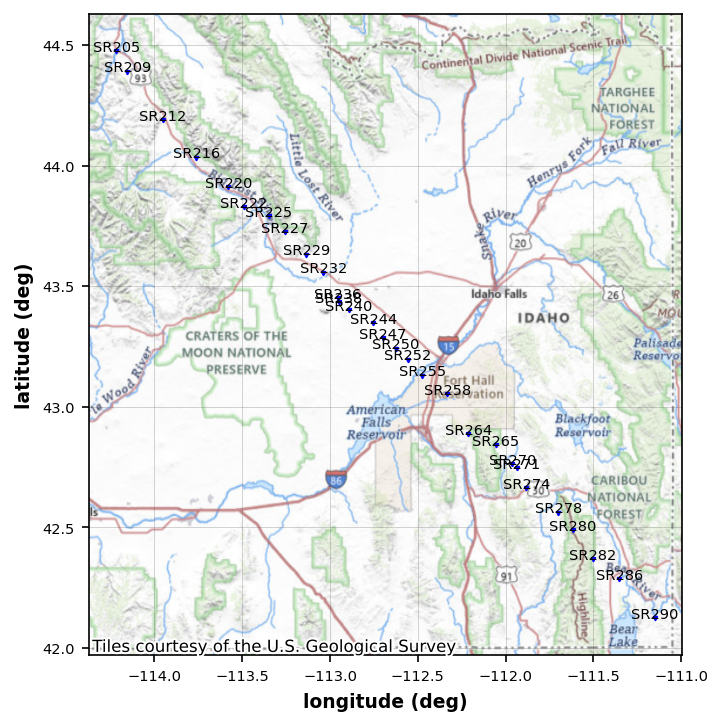

In [6]:
profile_stations_plot = profile.plot_stations()

## Interpolate data onto the same period map

It is important to use bounds_error=False, which will put Nan where data cannot be interpolated. Interpolate onto a period range that keeps the mesh small.  decrease the first number to get shorter periods. This is long period data so the smallest period is nominally 1 second but the first good period is usually 10 seconds.

In [7]:

profile.interpolate(np.logspace(1, 4, 5), inplace=True, bounds_error=False)


In [8]:
# 5) set data modeling errors, set an error floor of 5 % for the impedance
profile.z_model_error.error_value = 5
profile.z_model_error.error_type = "percent"
profile.z_model_error

Model Errors:
--------------------
	error_type:    percent
	error_value:   0.05
	floor:         True
	mode:          impedance

In [9]:
profile.compute_model_errors()

## Strike direction

Now with 2D inversions we need to maximize the components to be parallel and perpendicular to geoelectrical strike.  We can estimate the geoelectrical strike and plot per period.

24:10:30T22:48:27 | INFO | line:765 |mtpy.imaging.plot_strike | _plot_per_period | Note: North is assumed to be 0 and the strike angle is measuredclockwise positive.


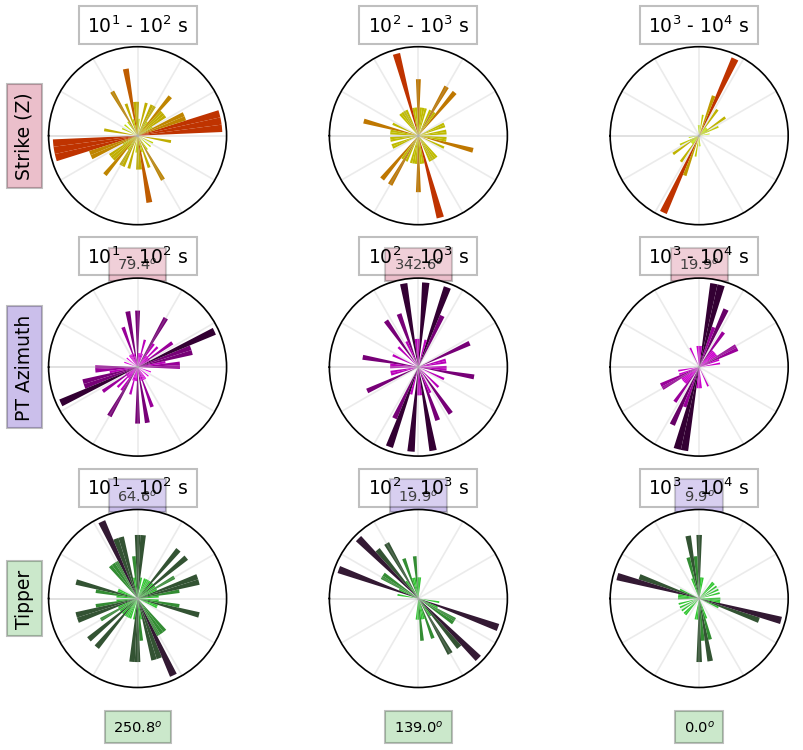

In [10]:
strike_plot = profile.plot_strike(plot_type=1)

From the plot we can see that there are few different strike angles.  And this is where you need to make an educated decision for which angle you want to rotate your data to maximize the TE and TM modes.  There is a dominant shallow strike of around N70E, then there is a deeper strike of around N20E and an even deeper strike of around N10E.  So you could do a couple of things. You could rotate to an average, mean, invert just a few periods at each strike angle, etc.  This is why 2D modeling is difficult.  Below is an example of how to rotate the data.  

### Data Rotation

Rotation is clockwise into strike, rotating North into East.  So if you have a strike angle of 10 you want to rotate your data 10 degrees to maximize the TE and TM modes.  

In [11]:
rotate_profile_n20e = profile.rotate(20, inplace=False)

24:10:30T22:49:05 | INFO | line:765 |mtpy.imaging.plot_strike | _plot_per_period | Note: North is assumed to be 0 and the strike angle is measuredclockwise positive.


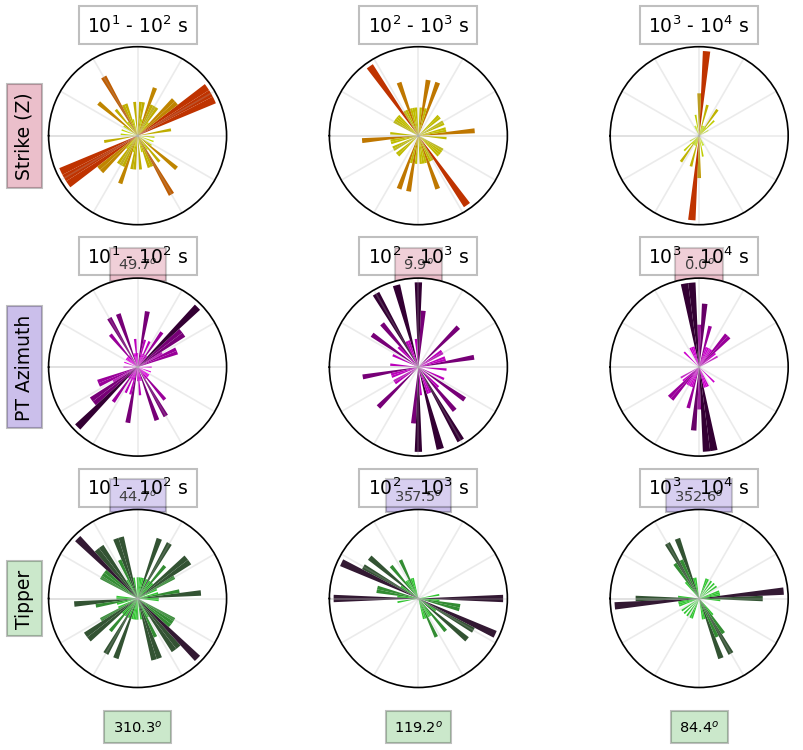

In [12]:
rotated_strike_plot = rotate_profile_n20e.plot_strike(plot_type=1)

## Run 2D inversion

Now use a somewhat standard recipe to invert the data.  User has lots of control of parameters for mesh building, inversion norms, smallness, etc.  This recipe is meant as a convenience object.  For advanced users and those who want to fully understand the Simpeg workflow should build their own recipe.

Here the input data is a Pandas Dataframe.  There is a method in MTData to create a Simpeg Data object.

Obviously, need to play around with mesh parameters.

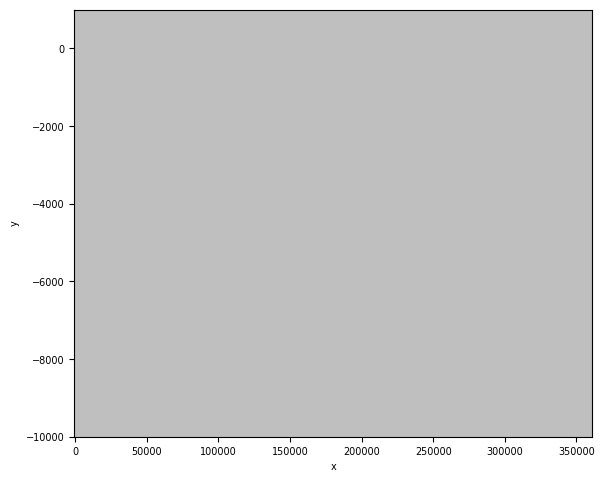

In [13]:
simpeg_2d = Simpeg2D(
    rotate_profile_n20e.to_dataframe(impedance_units="ohm"),
    mesh_kwargs={},
    data_kwargs={},
    max_iterations=10, 
    )

In [14]:
%%time
inversion_output = simpeg_2d.run_inversion()


Running inversion with SimPEG v0.22.2

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DMagneticField problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.23e-02  2.80e+08  0.00e+00  2.80e+08    6.81e+07      0              
   1  2.11e-02  3.81e+07  2.07e-02  3.81e+07    9.11e+06      0              
   2  1.06e-02  5.26e+06  8.34e-02  5.26e+06    1.22e+06      0   Skip BFGS  
   3  5.29e-03  7.67e+05  1.89e-01  7.67e+05    1.64e+05      0   Skip BFGS  
   4  2.64e-03  1.54e+05  3.39e-01  1.54e+05    2.28e+04      0   Skip BFGS  
   5  1.32e-03  7.39e+04  5.29e-01  7.39e+04    3.56e+03      0   

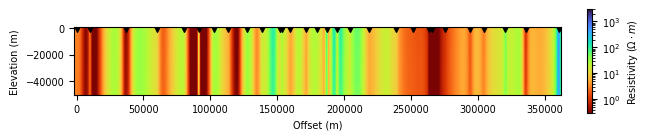

In [23]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(14,12))
simpeg_2d.plot_iteration(10, z_limits=(-50000, 500))

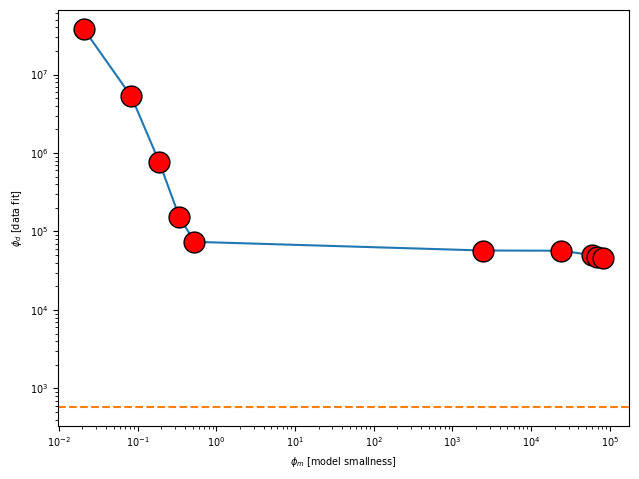

In [24]:
simpeg_2d.plot_tikhonov_curve()

In [25]:
simpeg_2d.plot_responses(10)

AttributeError: 'Simpeg2D' object has no attribute 'plot_responses'